In [1]:
# ! pip install transformers

In [1]:
import os
from transformers import (
    Trainer,
    BertTokenizer,
    BertModel
)
import transformers
import numpy as np
import pandas as pd

import random
import time
import yaml
from typing import *
from arguments import CustomTrainingArguments

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler

SEED = 10

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

# Display the entire text
pd.set_option("display.max_colwidth", None)

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
train_clean_path = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/NLP/nlp2022-hw3/model/data/train_clean.tsv"
valid_clean_path = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/NLP/nlp2022-hw3/model/data/valid_clean.tsv"

In [5]:
train_clean_path = "../../model/data/train_clean.tsv"
valid_clean_path = "../../model/data/valid_clean.tsv"

In [6]:
df_train = pd.read_csv(filepath_or_buffer=train_clean_path, sep="\t")
df_valid = pd.read_csv(filepath_or_buffer=valid_clean_path, sep="\t")

In [7]:
FEMININE = 0
MASCULINE = 1
UNKNOWN = 2

def get_gender(pronoun: str):
    gender_mapping = {
        'she': FEMININE,
        'her': FEMININE,
        'he': MASCULINE,
        'his': MASCULINE,
        'him': MASCULINE,
    }

    return gender_mapping.get(pronoun.lower(), UNKNOWN)

In [8]:
class GAPDataset(Dataset):
    """Custom GAP Dataset class"""

    def __init__(self, df, tokenizer, labeled=True):
        self.df = df

        self.labeled = labeled
        self.tokenizer = tokenizer
        self.offsets, self.tokens = [], []
#         self.original_offsets = []

        if labeled:
            self._extract_target()
            self.labels = df.target.values.astype("uint8")

        self._convert_tokens_to_ids()

    @staticmethod
    def get_class_id(is_coref_A: Union[str, bool], is_coref_B: Union[str, bool]) -> int:
        if is_coref_A == "TRUE" or is_coref_A is True:
            return 0
        elif is_coref_B == "TRUE" or is_coref_B is True:
            return 1
        else:
            return 2
        
    def _extract_target(self):
        self.df['target'] = [self.get_class_id(is_coref_A, is_coref_B) 
                             for is_coref_A, is_coref_B in zip(self.df['is_coref_A'],  
                                                               self.df['is_coref_B'])]
        
    def _convert_tokens_to_ids(self):
        CLS = [self.tokenizer.cls_token]
        SEP = [self.tokenizer.sep_token]

        for _, row in self.df.iterrows():
            tokens, offsets = self._tokenize(row)
#             self.original_offsets.append([row.offset_A, row.offset_B, row.p_offset])
            self.offsets.append(offsets)
            self.tokens.append(self.tokenizer.convert_tokens_to_ids(
                CLS + tokens + SEP))

    def _tokenize(self, row):
        # The order is important because we want the pronoun to come after all the
        # coreferenced entities in the output, even if B could come after the pronoun.
        break_points = sorted([
            ("A", row['offset_A'], row['entity_A']),
            ("B", row['offset_B'], row['entity_B']),
            ("P", row['p_offset'], row['pron'])
        ], key=lambda x: x[0])

        tokens, spans, current_pos = [], {}, 0
        for name, offset, text in break_points:
            tokens.extend(self.tokenizer.tokenize(
                row["text"][current_pos:offset]))
            # Make sure we do not get it wrong
            assert row["text"][offset:offset+len(text)] == text
            # Tokenize the target
            tmp_tokens = self.tokenizer.tokenize(
                row["text"][offset:offset+len(text)])

            # [num_tokens until entity, num_tokens including the entity]
            spans[name] = [len(tokens), len(tokens) +
                           len(tmp_tokens) - 1]  # inclusive
            # In the last iteration, the pronoun is appended to the end
            tokens.extend(tmp_tokens)
            current_pos = offset + len(text)

        tokens.extend(self.tokenizer.tokenize(row["text"][current_pos:offset]))

        # The pronoun is a single token, so the span is the same
        assert spans["P"][0] == spans["P"][1]
        return tokens, (spans["A"] + spans["B"] + [spans["P"][0]])

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        if self.labeled:
            return self.tokens[idx], self.offsets[idx], self.labels[idx] 
        return self.tokens[idx], self.offsets[idx], None

In [9]:
model_name_or_path = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name_or_path)

In [10]:
train_ds = GAPDataset(df_train[:100], tokenizer)
valid_ds = GAPDataset(df_valid[:50], tokenizer)

C:\Users\flori\miniconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
df_train['text'][0][274:]

"her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline."

In [12]:
def collate_batch(batch, truncate_len=400):
    """Batch preparation.

    1. Pad the sequences
    2. Transform the target.
    """
    batch_features, batch_offsets, batch_labels = zip(*batch)

    max_len = min(
        max((len(x) for x in batch_features)),
        truncate_len
    )

    # Features
    features = np.zeros((len(batch), max_len), dtype=np.int64)

    # Padding
    for i, row in enumerate(batch_features):
        features[i, :len(row)] = row

    features_tensor = torch.tensor(features, device=device)

    # Offsets
    offsets_tensor = torch.stack([
        torch.tensor(x, dtype=torch.int64, device=device) for x in batch_offsets
    ], dim=0) + 1  # Account for the [CLS] token

    # Labels
    if batch_labels[0] is None:
        return features_tensor, offsets_tensor, None

    labels_tensor = torch.tensor(
        batch_labels, dtype=torch.uint8, device=device)
    return features_tensor, offsets_tensor, labels_tensor

In [13]:
class Collator:
    def __init__(self, device):
        self.device = device
        
    def __call__(self, batch, truncate_len=400):
        """Batch preparation.

        1. Pad the sequences
        2. Transform the target.
        """
        batch_features, batch_offsets, batch_labels = zip(*batch)

        max_len = min(
            max((len(x) for x in batch_features)),
            truncate_len
        )

        # Features
        features = np.zeros((len(batch), max_len), dtype=np.int64)

        # Padding
        for i, row in enumerate(batch_features):
            features[i, :len(row)] = row

        features_tensor = torch.tensor(features, device=self.device)

        # Offsets
        offsets_tensor = torch.stack([
            torch.tensor(x, dtype=torch.int64, device=self.device) for x in batch_offsets
        ], dim=0) + 1  # Account for the [CLS] token

        # Labels
        if batch_labels[0] is None:
            return features_tensor, offsets_tensor, None

        labels_tensor = torch.tensor(
            batch_labels, dtype=torch.uint8, device=self.device)
        return features_tensor, offsets_tensor, labels_tensor

In [14]:
class CorefHead(nn.Module):
    def __init__(self, bert_hidden_size: int):
        super().__init__()
        self.bert_hidden_size = bert_hidden_size
        self.head_hidden_size = 512

#         self.fc = nn.Sequential(
#             nn.Dropout(0.1),
#             nn.Linear(bert_hidden_size * 3, 512),
#             nn.ReLU(),
#             nn.Linear(512, 3)
#         )

        # a) Always BN -> AC, (Nothing b/w them).
        # b) BN -> Dropout over Dropout -> BN, but try both. [Newer research, finds 1st better ]
        # c) BN eliminates the need of Dropout, no need to use Dropout.
        # e) BN before Dropout is data Leakage.
        # f) Best thing is to try every combination.
        # SO CALLED BEST METHOD -
        # Layer -> BN -> AC -> Dropout ->Layer

        self.fc = nn.Sequential(
            #             nn.BatchNorm1d(bert_hidden_size * 3),
            #             nn.Dropout(0.5),
            #             nn.LeakyReLU(),
            #             nn.Linear(bert_hidden_size * 3, self.head_hidden_size),
            #             nn.BatchNorm1d(self.head_hidden_size),
            #             nn.Dropout(0.5),
            #             nn.Linear(self.head_hidden_size, self.head_hidden_size),
            #             nn.ReLU(),
            #             nn.BatchNorm1d(self.head_hidden_size),
            #             nn.Dropout(0.5),
            nn.Dropout(0.1),
            nn.Linear(bert_hidden_size * 3, self.head_hidden_size),
            nn.BatchNorm1d(self.head_hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.head_hidden_size, 3)
        )

    def forward(self, bert_outputs, offsets):
        assert bert_outputs.shape[2] == self.bert_hidden_size
        embeddings = self._retrieve_entities_and_pron_embeddings(bert_outputs,
                                                           offsets)

        return self.fc(embeddings)
    
    def _retrieve_entities_and_pron_embeddings(self, bert_embeddings, entities_and_pron_offsets):
        embeddings_A = []
        embeddings_B = []
        embeddings_pron = []

        # Consider embeddings and offsets in each batch separately
        for embeddings, off in zip(bert_embeddings, entities_and_pron_offsets):
            # The offsets of mention A are the first and the second
            # in the 'off' tensor
            offsets_ent_A = range(off[0], off[1]+1)
            # The offsets of mention B are the third and the fourth
            # in the 'off' tensor
            offsets_ent_B = range(off[2], off[3]+1)
            # The offset of the pronoun is the last in the 'off' tensor
            offset_pron = off[-1]

            # The embedding of a mention is the mean of
            # all the subtokens embeddings that represent it
            embeddings_A.append(embeddings[offsets_ent_A].mean(dim=0))
            embeddings_B.append(embeddings[offsets_ent_B].mean(dim=0))
            embeddings_pron.append(embeddings[offset_pron])

        # Merge outputs
        merged_entities_and_pron_embeddings = torch.cat([
            torch.stack(embeddings_A, dim=0),
            torch.stack(embeddings_B, dim=0),
            torch.stack(embeddings_pron, dim=0)
        ], dim=1)
        # print(torch.stack(outputs_A, dim=0))
        # torch.stack(outputs_B, dim=0)
        # print(torch.stack(outputs_pron, dim=0))

        # shape: batch_size x (embedding_dim * 3)
        return merged_entities_and_pron_embeddings

In [15]:
class GAPModel(nn.Module):
    """The main model."""

    def __init__(self, bert_model: str):
        super().__init__()

        if bert_model in ("bert-base-uncased", "bert-base-cased"):
            self.bert_hidden_size = 768
        elif bert_model in ("bert-large-uncased", "bert-large-cased"):
            self.bert_hidden_size = 1024
        else:
            raise ValueError("Unsupported BERT model.")

        self.bert = BertModel.from_pretrained(
            bert_model).to(device, non_blocking=True)
        self.head = CorefHead(self.bert_hidden_size).to(
            device, non_blocking=True)

    def forward(self, x, offsets):
        bert_outputs = self.bert(
            x, attention_mask=(x > 0).long(),
            token_type_ids=None, output_hidden_states=True)
#         concat_bert = torch.cat((bert_outputs[-1],bert_outputs[-2],bert_outputs[-3]),dim=-1)

        last_layer = bert_outputs.last_hidden_state
        head_outputs = self.head(last_layer, offsets)
#         return concat_bert
        return head_outputs

GradScaler: https://pytorch.org/docs/stable/notes/amp_examples.html#gradient-clipping

https://pytorch.org/docs/stable/amp.html#gradient-scaling

**Gradient Scaling**

If the forward pass for a particular op has float16 inputs, the backward pass for that op will produce float16 gradients. Gradient values with small magnitudes may not be representable in float16. These values will flush to zero (“underflow”), so the update for the corresponding parameters will be lost.

To prevent underflow, “gradient scaling” multiplies the network’s loss(es) by a scale factor and invokes a backward pass on the scaled loss(es). Gradients flowing backward through the network are then scaled by the same factor. In other words, gradient values have a larger magnitude, so they don’t flush to zero.

The method `step(optimizer, *args, **kwargs)` internally invokes `unscale_(optimizer)`and if no inf/NaN gradients are found, invokes `optimizer.step()` using the unscaled gradients. Otherwise `optimizer.step()` is skipped to avoid corrupting the params.

\**Note for Gradient Clipping*

If you wish to modify the gradients (like in gradient clipping), you should unscale them first. If you attempted to clip *without* unscaling, the gradients' norm magnitude would also be scaled, so your requested threshold would be invalid.

In [16]:
# class Trainer:
    
#     def __init__(
#         self,
#         model: nn.Module,
#         args: TrainingArguments,
#         train_dataloader: DataLoader,
#         valid_dataloader: DataLoader,
#         criterion: torch.nn,
#         optimizer: torch.optim.Optimizer,
#         scheduler: torch.optim.lr_scheduler = None,
        
#     ):
        
#         self.model = model
#         self.train_dataloader = train_dataloader
#         self.valid_dataloader = valid_dataloader
#         self.criterion = criterion
#         self.optimizer = optimizer
#         self.scheduler = scheduler
        
#         if args is None:
#             output_dir = "../../model/tmp_trainer"
#             print(f"No 'TrainingArguments' passed, using 'output_dir={output_dir}'.")
#             args = TrainingArguments(output_dir=output_dir)
        
#         self.args = args
        
#     def train(self, grad_clipping, save_model):
#         args = self.args
#         train_dataloader = self.train_dataloader
#         valid_dataloader = self.valid_dataloader
        
#         train_losses = []
#         train_acc_list = []
#         valid_losses = []
#         valid_acc_list = []
        
#         epochs = args.num_train_epochs
#         train_loss = 0.0
#         train_acc, total_count = 0.0, 0.0
#         training_start_time = time.time()
        
#         scaler = GradScaler()
#         self.model.train()
#         for epoch in range(epochs):
#             epoch_loss = 0.0
            
#             for step, (features, offsets, labels) in enumerate(train_dataloader):
#                 # Empty gradients
#                 self.optimizer.zero_grad(set_to_none=True)
                
#                 # Forward
# #                 predictions = self.model(features, offsets)
# #                 loss = self.criterion(predictions, labels)
#                 # Forward pass with mixed precision
#                 with torch.cuda.amp.autocast(): # autocast as a context manager
#                     predictions = self.model(features, offsets)
#                     loss = self.criterion(predictions, labels)
                
#                 train_acc += (predictions.argmax(1) == labels).sum().item()
#                 total_count += labels.shape[0]
                
# #                 # Backward  
# #                 loss.backward()
#                 # Backward pass without mixed precision
#                 # It's not recommended to use mixed precision for backward pass
#                 # Because we need more precise loss
#                 scaler.scale(loss).backward()
                
#                 torch.nn.utils.clip_grad_norm_(self.model.parameters(), grad_clipping)
                
#                 # Update weights 
# #                 self.optimizer.step()
#                 scaler.step(self.optimizer)
#                 scaler.update()
        
                
#                 epoch_loss += loss.tolist()

#                 if step % args.logging_steps == args.logging_steps - 1:
#                     mid_loss = epoch_loss / (step + 1)
#                     mid_acc = train_acc / total_count
# #                     print('\t[E: {:2d} @ step {}] current avg loss = {:0.4f}'.format(epoch, step, mid_loss))
#                     print(f'\t| step {step+1:3d}/{len(train_dataloader):d} | train_loss: {mid_loss:.3f} | ' \
#                     f'train_acc: {mid_acc:.3f} |')
            
#             avg_epoch_loss = epoch_loss / len(train_dataloader)
#             train_loss += avg_epoch_loss
#             train_losses.append(train_loss)
#             train_acc_list.append(train_acc / total_count)
            
# #             print('\t[E: {:2d}] train loss = {:0.4f}'.format(epoch, avg_epoch_loss))  # print train loss at the end of the epoch
            
    
#             valid_loss, valid_acc = self.evaluate(valid_dataloader)
#             valid_losses.append(valid_loss)
#             valid_acc_list.append(valid_acc)
            
# #             print('  [E: {:2d}] valid loss = {:0.4f}'.format(epoch, valid_loss))
#             print('-' * 74)
#             print(f'| epoch {epoch+1:3d}/{epochs:d} | train_loss: {avg_epoch_loss:.3f} | ' \
#                     f'valid_loss: {valid_loss:.3f} | valid_acc: {valid_acc:.3f} |')
#             print('-' * 74)

            
#         training_time = time.time() - training_start_time
#         print(f'Training time: {training_time:.2f}s')
#         avg_epoch_loss = train_loss / epochs
#         histories = {
#             "train_losses": train_losses,
#             "train_acc": train_acc_list,
#             "valid_losses": valid_losses,
#             "valid_acc": valid_acc_list,

#         }
#         print(histories)
#         if save_model:
#             self._save_model(epoch, valid_acc)
    
    
#         return #avg_epoch_loss, histories
            
#     def evaluate(self, eval_dataloader):
#         valid_loss = 0.0
#         eval_acc, total_count = 0, 0
        
#         self.model.eval()
#         with torch.no_grad():
#             for (features, offsets, labels) in eval_dataloader:
                
#                 predictions = self.model(features, offsets)
#                 loss = self.criterion(predictions, labels)
#                 valid_loss += loss.tolist()

#                 eval_acc += (predictions.argmax(1) == labels).sum().item()
#                 total_count += labels.shape[0]
        
#         return valid_loss / len(eval_dataloader), eval_acc / total_count
    
#     def _save_model(self, epoch, valid_acc):
#         torch.save({
#                 "epoch": epoch,
#                 "model_state_dict": self.model.state_dict(),
#                 "optimizer_state_dict": self.optimizer.state_dict(),
#             }, f"{self.args.output_dir}my_model_{str(valid_acc)[2:5]}_{epoch+1}.pth")

In [28]:
class Trainer:
    
    def __init__(
        self,
        model: nn.Module,
        args: CustomTrainingArguments,
        train_dataloader: DataLoader,
        valid_dataloader: DataLoader,
        criterion: torch.nn,
        optimizer: torch.optim.Optimizer,
        scheduler: torch.optim.lr_scheduler = None,
        
    ):
        
        self.model = model
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        
        if args is None:
            output_dir = "../../model/tmp_trainer"
            print(f"No 'TrainingArguments' passed, using 'output_dir={output_dir}'.")
            args = CustomTrainingArguments(output_dir=output_dir)
        
        self.args = args
        
    def train(self):
        args = self.args
        valid_dataloader = self.valid_dataloader
        epochs = args.num_train_epochs
        
        train_losses = []
        train_acc_list = []
        valid_losses = []
        valid_acc_list = []
        
        if args.early_stopping:
            patience_counter = 0 

        scaler = GradScaler()

        if args.resume_from_checkpoint is not None:
            self._resume_model(args.resume_from_checkpoint, scaler)

        training_start_time = time.time()
        print("\nTraining...")
        for epoch in range(epochs):
            train_loss, train_acc = self._inner_training_loop(scaler)
            train_losses.append(train_loss)
            train_acc_list.append(train_acc)

            valid_loss, valid_acc = self.evaluate(valid_dataloader)
            valid_losses.append(valid_loss)
            valid_acc_list.append(valid_acc)

            if self.scheduler is not None:
                print('-' * 14)
                print(f"  LR: {self.scheduler.get_last_lr()[0]:.2e}")
                self.scheduler.step()
            
            
            self._print_epoch_log(epoch, epochs, train_loss, valid_loss, valid_acc)

            if args.early_stopping and len(valid_acc_list) >= 2:
                # stop = args.early_stopping_mode == 'min' and epoch > 0 and valid_acc_list[-1] > valid_acc_list[-2]
                stop = args.early_stopping_mode == 'max' and epoch > 0 and valid_acc_list[-1] < valid_acc_list[-2]
                if stop:
                    if patience_counter >= args.early_stopping_patience:
                        print('Early stop.')
                        break
                    else:
                        print('-- Patience.\n')
                        patience_counter += 1
        
        training_time = time.time() - training_start_time
        print(f'Training time: {training_time:.2f}s')

        metrics_history = {
            "train_losses": train_losses,
            "train_acc": train_acc_list,
            "valid_losses": valid_losses,
            "valid_acc": valid_acc_list,
        }
#         print(metrics_history)
        if args.save_model:
            self._save_model(epoch, valid_acc, scaler)
    
        return metrics_history

    def _inner_training_loop(self, scaler):
        args = self.args
        train_dataloader = self.train_dataloader
        
        train_loss = 0.0
        train_acc, total_count = 0.0, 0.0

        self.model.train()
        for step, (features, offsets, labels) in enumerate(train_dataloader):
            # Empty gradients
            self.optimizer.zero_grad(set_to_none=True)
            
            # Forward
            predictions = self.model(features, offsets)
            loss = self.criterion(predictions, labels)
            # with torch.cuda.amp.autocast(): # autocast as a context manager
            #     predictions = self.model(features, offsets)
            #     loss = self.criterion(predictions, labels)

            train_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.shape[0]
            
#                 # Backward  
            # loss.backward()
            # Backward pass without mixed precision
            # It's not recommended to use mixed precision for backward pass
            # Because we need more precise loss
            scaler.scale(loss).backward()
            
            scaler.unscale_(optimizer)
            
            if args.grad_clipping is not None:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), args.grad_clipping)
            
            # Update weights 
            # self.optimizer.step()
            scaler.step(self.optimizer)
            scaler.update()

            train_loss += loss.item()

            if step % args.logging_steps == args.logging_steps - 1:
                running_loss = train_loss / (step + 1)
                running_acc = train_acc / total_count
                self._print_step_log(step, running_loss, running_acc)
                
        return train_loss / len(train_dataloader), train_acc / total_count


    def evaluate(self, eval_dataloader):
        valid_loss = 0.0
        eval_acc, total_count = 0, 0
        
        self.model.eval()
        with torch.no_grad():
            for (features, offsets, labels) in eval_dataloader:
                
                predictions = self.model(features, offsets)
                loss = self.criterion(predictions, labels)
                valid_loss += loss.item()

                eval_acc += (predictions.argmax(1) == labels).sum().item()
                total_count += labels.shape[0]
        
        return valid_loss / len(eval_dataloader), eval_acc / total_count


    def _print_step_log(self, step, running_loss, running_acc):
        print(f'\t| step {step+1:3d}/{len(self.train_dataloader):d} | train_loss: {running_loss:.3f} | ' \
                f'train_acc: {running_acc:.3f} |')

    def _print_epoch_log(self, epoch, epochs, train_loss, valid_loss, valid_acc):
        print('-' * 74)
        print(f'| epoch {epoch+1:3d}/{epochs:d} | train_loss: {train_loss:.3f} | ' \
                f'valid_loss: {valid_loss:.3f} | valid_acc: {valid_acc:.3f} |')
        print('-' * 74)
        
    
    def _save_model(self, epoch, valid_acc, scaler):
        print("Saving model...")
        torch.save({
                "epoch": epoch,
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "scaler_state_dict": scaler.state_dict(),
            }, f"{self.args.output_dir}my_model_{str(valid_acc)[2:5]}_{epoch+1}.pth")
        print("Model saved.")

    def _resume_model(self, path, scaler):
        checkpoint = torch.load(path, map_location=device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scaler.load_state_dict(checkpoint['scaler_state_dict'])


In [33]:
model = GAPModel(model_name_or_path).to(device, non_blocking=True)

yaml_file = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/NLP/nlp2022-hw3/hw3/stud/train_notebook.yaml"
yaml_file = "./train_notebook.yaml"
# Read configuration file with all the necessary parameters
with open(yaml_file) as file:
    config = yaml.safe_load(file)
    
training_args = CustomTrainingArguments(**config['training_args'])

# Make sure that the learning rate is read as a number and not as a string
training_args.learning_rate = float(training_args.learning_rate)


criterion = torch.nn.CrossEntropyLoss().to(device=device, non_blocking=True)
optimizer = torch.optim.Adam(model.parameters(), lr=training_args.learning_rate)
# scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

batch_size = 4

train_dataloader = DataLoader(train_ds, batch_size=batch_size, 
                              collate_fn=collate_batch, shuffle=True)
valid_dataloader = DataLoader(valid_ds, batch_size=batch_size, 
                              collate_fn=collate_batch, shuffle=False)

trainer = Trainer(model, training_args, 
                  train_dataloader, valid_dataloader, 
                  criterion, optimizer, scheduler)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
metrics_history = trainer.train()


Training...
	| step  10/25 | train_loss: 1.638 | train_acc: 0.450 |
	| step  20/25 | train_loss: 1.557 | train_acc: 0.475 |
--------------
  LR: 4.55e-03
--------------------------------------------------------------------------
| epoch   1/10 | train_loss: 1.585 | valid_loss: 0.781 | valid_acc: 0.560 |
--------------------------------------------------------------------------
	| step  10/25 | train_loss: 1.721 | train_acc: 0.375 |
	| step  20/25 | train_loss: 1.655 | train_acc: 0.362 |
--------------
  LR: 4.55e-03
--------------------------------------------------------------------------
| epoch   2/10 | train_loss: 1.581 | valid_loss: 3.030 | valid_acc: 0.020 |
--------------------------------------------------------------------------
	| step  10/25 | train_loss: 1.454 | train_acc: 0.425 |
	| step  20/25 | train_loss: 1.395 | train_acc: 0.388 |
--------------
  LR: 4.55e-03
--------------------------------------------------------------------------
| epoch   3/10 | train_loss: 1.473

In [ ]:
metrics_history

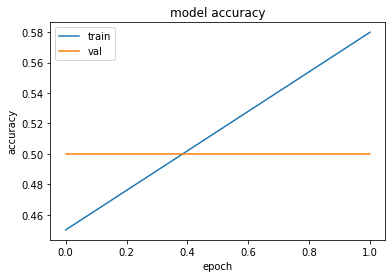

In [28]:
from matplotlib import pyplot as plt
plt.plot(metrics_history['train_acc'])
plt.plot(metrics_history['valid_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
from transformers import get_linear_schedule_with_warmup


scheduler = get_linear_schedule_with_warmup()

TypeError: get_linear_schedule_with_warmup() missing 3 required positional arguments: 'optimizer', 'num_warmup_steps', and 'num_training_steps'

In [21]:
model_resumed = GAPModel(model_name_or_path).to(device, non_blocking=True)
optimizer_resumed = torch.optim.Adam(model_resumed.parameters())

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
path = "../../model/checkpoints/my_model_850_6.pth"

In [22]:
checkpoint = torch.load(path, map_location=device)
model_resumed.load_state_dict(checkpoint['model_state_dict'])
optimizer_resumed.load_state_dict(checkpoint['optimizer_state_dict'])

In [24]:
# del checkpoint

In [23]:
optimizer_resumed

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 5e-06
    maximize: False
    weight_decay: 0
)

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(train_ds[0][0])
# tokens[train_ds[0][1][0] - 1]
train_ds[0][1]

[41, 42, 44, 44, 61]

In [ ]:
tokens[42:44]

['cheryl', 'cassidy']

A List with your predictions.

Each prediction is a tuple, composed by two tuples:
(ambigous_pronoun, ambiguous_pronoun_offset), (coreferent_entity, coreferent_entity_offset))

for example:
    [(('her', 274), ('Pauline', 418))]

I need to know the original positions.

The model return the label prediction (0 1 2)

If pred == 0 => A

elif pred == 1 => B

else => --

I have to know:
1. The pronoun and its pos
2. The predicted entity and its pos


1. I can retrieve the pronoun through the last offset in offsets after encoding the ids.
    I also need its original position.
    
2. 
    


In [33]:
def read_dataset(path: str) -> List[Dict]:
    samples: List[Dict] = []
    pron_counter = Counter()
    with open(path) as f:
        next(f)
        for line in f:
            (
                id,
                text,
                pron,
                p_offset,
                entity_A,
                offset_A,
                is_coref_A,
                entity_B,
                offset_B,
                is_coref_B,
                url,
            ) = line.strip().split("\t")
            pron_counter[pron.lower()] += 1
            samples.append(
                {
                    "id": id,
                    "text": text,
                    "pron": pron,
                    "p_offset": int(p_offset),
                    "entity_A": entity_A,
                    "offset_A": int(offset_A),
                    "is_coref_A": is_coref_A,
                    "entity_B": entity_B,
                    "offset_B": int(offset_B),
                    "is_coref_B": is_coref_B,
                    "url": url,
                }
            )
    print(pron_counter)
    return samples, pron_counter

In [34]:
train_path = "../../model/data/train.tsv"
valid_path = "../../model/data/dev.tsv"

In [35]:
train_dataset, train_pron_counter = read_dataset(train_path)
valid_dataset, valid_pron_counter = read_dataset(valid_path)

Counter({'his': 904, 'her': 773, 'he': 610, 'she': 555, 'him': 157})
Counter({'her': 140, 'his': 108, 'he': 93, 'she': 87, 'him': 26})


In [ ]:
train_dataset[0]

{'id': 'train-1',
 'text': "Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.",
 'pron': 'her',
 'p_offset': 274,
 'entity_A': 'Cheryl Cassidy',
 'offset_A': 191,
 'is_coref_A': 'TRUE',
 'entity_B': 'Pauline',
 'offset_B': 207,
 'is_coref_B': 'FALSE',
 'url': 'http://en.wikipedia.org/wiki/List_of_Teachers_(UK_TV_series)_characters'}

In [30]:
def get_entity_and_offset_from_id(label_id, sentence):
    if label_id == 0: # Entity A
        return sentence['entity_A'], sentence['offset_A']
    elif label_id == 1: # Entity B
        return sentence['entity_B'], sentence['offset_B']
    else: # Neither
        return None, None 

In [ ]:
get_entity_and_offset_from_id(2, train_dataset[0])

(None, None)

In [31]:
def predict(model, sentences: List[Dict]) -> List[Tuple[Tuple[str, int], Tuple[str, int]]]:
    df = pd.DataFrame(sentences)
    
    # tokenizer will be self.tokenizer in the final implementation
    dataset = GAPDataset(df, tokenizer)
    collator = Collator(device)

    predictions = []
    
    #self.model.eval()
    model.eval()
    with torch.no_grad():
        dataloader = DataLoader(dataset, batch_size=1, 
                                collate_fn=collator, shuffle=False)
        
        for (features, offsets, labels), sentence in zip(dataloader, sentences):
            
#             predictions = self.model(features, offsets).argmax(1).item()
            predicted_label_id = model(features, offsets).argmax(1).item()
            pred_entity, pred_entity_offset = get_entity_and_offset_from_id(predicted_label_id, sentence)
            pron, pron_offset = sentence['pron'],  sentence['p_offset']
            
            predictions.append(((pron, pron_offset), (pred_entity, pred_entity_offset)))
            
    return predictions
            

In [36]:
pred = predict(model, valid_dataset)

In [48]:
gold_values = []
for sentence in valid_dataset:
    gold_both_wrong = sentence["is_coref_A"] == "FALSE" and sentence["is_coref_B"] == "FALSE"
    if gold_both_wrong:
        gold_entity_offset = None
        gold_entity = None
    else:
        gold_entity_offset = (
            sentence["offset_A"] if sentence["is_coref_A"] == "TRUE" else sentence["offset_B"]
        )
        gold_entity = (
            sentence["entity_A"] if sentence["is_coref_A"] == "TRUE" else sentence["entity_B"]
        )
    
    
    gold_values.append(((sentence['pron'], sentence['p_offset']),(gold_entity, gold_entity_offset)))

In [79]:
a = {}

a.setdefault("age", 0)
a.setdefault("age", 5)

0

In [80]:
a['a'] = 0
a

{'age': 0, 'a': 0}

In [55]:
wrong = []
for p, g in zip(pred, gold_values):
    if g[1][0] != p[1][0]:
        wrong.append((g, p))
#     print(p[1], g[1])

In [88]:
pr = wrong[0][0][0][0]
get_gender("she")

gender = {}

for pair in wrong:
    pr = pair[0][0][0]
    gender.setdefault(get_gender(pr.lower()), 0)
    gender[get_gender(pr.lower())] += 1 


In [89]:
gender

{1: 35, 0: 34}

In [ ]:
valid_dataset[1]

{'id': 'validation-2',
 'text': "Kathleen Nott was born in Camberwell, London. Her father, Philip, was a lithographic printer, and her mother, Ellen, ran a boarding house in Brixton; Kathleen was their third daughter. She was educated at Mary Datchelor Girls' School (now closed), London, before attending King's College, London.",
 'pron': 'She',
 'p_offset': 185,
 'entity_A': 'Ellen',
 'offset_A': 110,
 'is_coref_A': 'FALSE',
 'entity_B': 'Kathleen',
 'offset_B': 150,
 'is_coref_B': 'TRUE',
 'url': 'http://en.wikipedia.org/wiki/Kathleen_Nott'}

In [37]:
def compute_metrics(predictions_s, samples):
    total = 0
    correct = 0
    for pred, label in zip(predictions_s, samples):
        gold_pron_offset = label["p_offset"]
        pred_pron_offset = pred[0][1] if len(pred[0]) > 0 else None
        gold_pron = label["pron"]
        pred_pron = pred[0][0] if len(pred[0]) > 0 else None
        gold_both_wrong = label["is_coref_A"] == "FALSE" and label["is_coref_B"] == "FALSE"
        pred_entity_offset = pred[1][1] if len(pred[1]) > 0 else None
        pred_entity = pred[1][0] if len(pred[1]) > 0 else None
              
        if gold_both_wrong:
            if pred_entity is None and gold_pron_offset == pred_pron_offset and gold_pron == pred_pron:
                correct += 1
            total += 1
        else:
            gold_entity_offset = (
                label["offset_A"] if label["is_coref_A"] == "TRUE" else label["offset_B"]
            )
            gold_entity = (
                label["entity_A"] if label["is_coref_A"] == "TRUE" else label["entity_B"]
            )
            if (
                gold_pron_offset == pred_pron_offset
                and gold_pron == pred_pron
                and gold_entity_offset == pred_entity_offset
                and gold_entity == pred_entity
            ):
                correct += 1
            total += 1
    
    print(f"# instances: {total}")
    acc = float(correct) / total
    print(f"# accuracy: {acc:.4f}")

In [38]:
compute_metrics(pred, valid_dataset)

# instances: 454
# accuracy: 0.8480


In [2]:
from arguments import CustomTrainingArguments
a = CustomTrainingArguments(output_dir="c")

In [3]:
a

CustomTrainingArguments(output_dir='c', resume_from_checkpoint=None, save_model=False, num_train_epochs=3, logging_steps=250, learning_rate=0.0005, grad_clipping=None, early_stopping=False, early_stopping_mode='max', early_stopping_patience=0)

In [129]:
from arguments import CustomTrainingArguments

yaml_file = "./train.yaml"

# Read configuration file with all the necessary parameters
with open(yaml_file) as file:
    config = yaml.safe_load(file)
    
arg = CustomTrainingArguments(**config['training_args'])

TypeError: __init__() got an unexpected keyword argument 'resume_from_checkpoint'

In [120]:
print(arg)

CustomTrainingArguments(output_dir='../../model/checkpoints/', num_train_epochs=6, logging_steps=250, save_model=False, learning_rate=5e-06, grad_clipping=None, early_stopping=False, early_stopping_mode='max', early_stopping_patience=0)
